













































# Lab 2: Logistic regression - Titanic

https://www.kaggle.com/c/titanic/data

In [86]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [87]:
import sklearn as sk

In [88]:
filename = 'titanic'

from urllib.request import urlretrieve
urlretrieve("https://bianchi.wp.imt.fr/files/2023/12/titanic.zip", filename + '.zip')

import os
zip_file = os.path.join(os.getcwd(), 'titanic.zip')

import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [89]:
df = pd.read_csv("traintitanic.csv")


In [90]:
# Using head(), info(), describe() etc. inspect the dataset. Which features are numerical, which ones are categorical? Comment about missing data.

#SibSP: how many siblings & spouses of the passenger aboard the Titanic
#Parch: how many children & parents of the passenger aboard the Titanic.
#embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

df.head(10)
#numerical: PassengerId, Age, SibSP, Parch, Fare
#categorical: Survived, Pclass, Name, Sex, Ticket, Cabin, Embarked

df.info()
#Nan values contained in Age, Cabin, Embarked columns. 
#Initial plan: Nan Age will be filled in using median or mean age of the respective classes

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [91]:
# Using the df.groupby("Pclass"), comment about the nature of the passengers as a function of the class ticket (first, second or third class)
df.groupby("Pclass").mean()
# Group 1 has the highest survival rate, the highest age, and the highest fare, and had the lowest amount of parents + children. 
# Group 2 was the middle of most features, had similar mean # of siblings + spouses to group 1, had similar mean # of parents + children as group 3
# Group 3 has the lowest survival rage, age, and fare. However, has higher siblings + spouses count. 

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


Text(0.5, 1.0, "histogram of Passenger's classes")

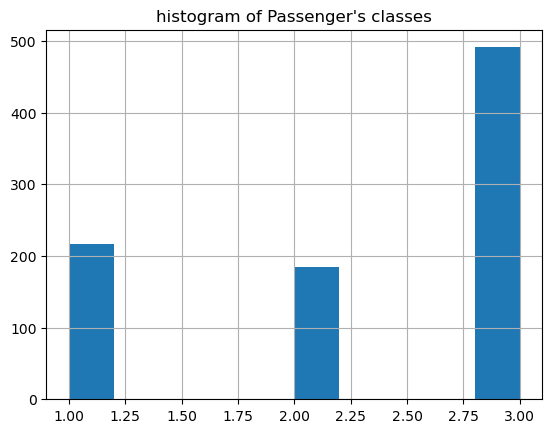

In [92]:
# Plot the histogram of Passenger's classes
df["Pclass"].hist()
plt.title("histogram of Passenger's classes")

In [93]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [94]:
# Comment about the impact of the sex of passengers
male_mean_survival = df["Survived"][df["Sex"] == "male"].mean()
female_mean_survival = df["Survived"][df["Sex"] == "female"].mean()
print(" male mean survival rate: ", male_mean_survival, "\n", "female mean survival rate: ", female_mean_survival)

#female passengers had a much higher survival rate than that of male passengers

 male mean survival rate:  0.18890814558058924 
 female mean survival rate:  0.7420382165605095


In [95]:
# Comment about the impact of the embarkation city. How do you explain the discrepancies in survival rate?
df["Embarked"].unique()
#['S', 'C', 'Q', nan]

S_mean_survival = df["Survived"][df["Embarked"] == 'S'].mean()
C_mean_survival = df["Survived"][df["Embarked"] == 'C'].mean()
Q_mean_survival = df["Survived"][df["Embarked"] == 'Q'].mean()

print(" Cherbourg mean survival rate: ", C_mean_survival, "\n", 
      "Southampton mean survival rate: ", S_mean_survival, "\n", 
     "Queenstown mean survival rate: ", Q_mean_survival)

#We can see that passengers embarking from Cherbourg has a much higher survival rate than passengers departing from Southampton and Queenstown. 
#However, since embarkation city does not have an direct effect on survival rate and we have not controlled for other factors, 
#the hypothesis is that passengers that embarked from Cherbourg is different in some other feature that has a more direct
#causal effect on survival rate, such as "Pclass".


 Cherbourg mean survival rate:  0.5535714285714286 
 Southampton mean survival rate:  0.33695652173913043 
 Queenstown mean survival rate:  0.38961038961038963


Text(0.5, 1.0, 'number of men (blue) and women (red) in each class')

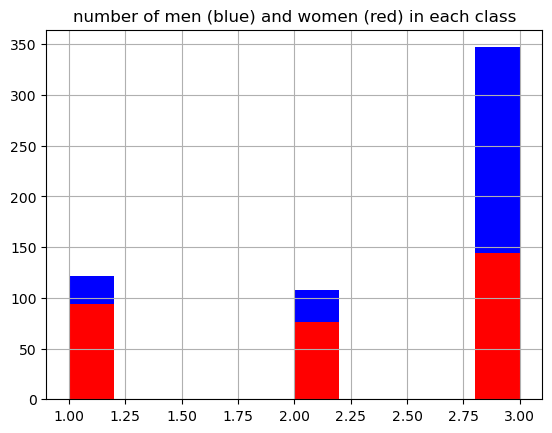

In [96]:
#Plot the histogram of the number of men in each class. Do the same for women. Comment.

male_distribution_by_class = df["Pclass"][df["Sex"] == "male"].hist(color = "blue")
female_distribution_by_class = df["Pclass"][df["Sex"] == "female"].hist(color = "red")
plt.title("number of men (blue) and women (red) in each class")

#The distribution of men in each class matches the distribution of passengers in each class, with the third class having by 
#far the most passengers. However, the women distribution is much less representative of the class passenger distribution,
#while still showing the same hierarchy in passenger count, the third class only has slightly more female passengers than the other
#2 classes. 

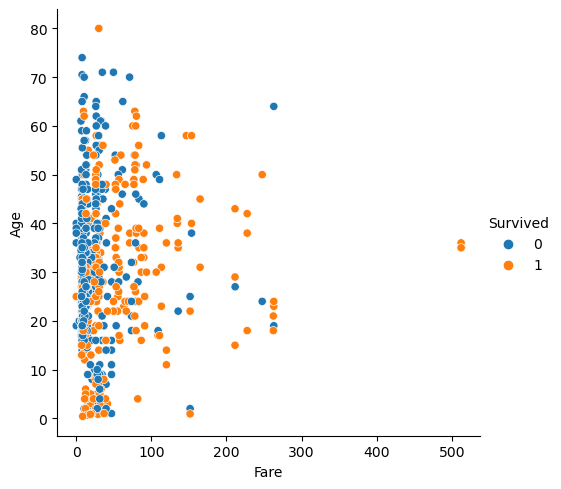

In [97]:
# Comment briefly the following code
sns.relplot(data=df,x="Fare", y="Age",hue="Survived")
#Those that paid more in fare seems to have a higher survival rate. There also seems to be a trend that younger passengers
#have higher survival rates, with those under ~8 years old having mostly survived. 

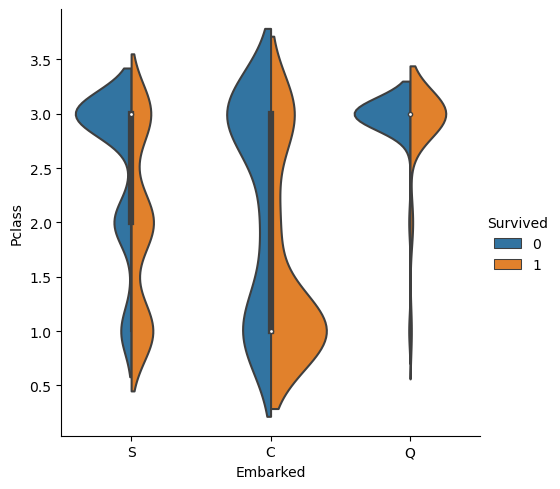

In [98]:
# In case you believe that other plots are interesting to vizualize the data set, you can provide them here.
sns.catplot(data=df, x="Embarked", y="Pclass", hue="Survived", kind="violin", split=True)
#I wanted to visualize the relationship between embarkation location and classes since I think maybe specific sites have
#have a higher concentration in a specific class. We can see from the plot that those who embarked from Queenstown 
#are mostly third class passengers while those who embarked from Cherbourg has a higher percentage of first class 
#passengers (keeping in mind that the first class has the least amount of passengers). This can show some insight as to 
#how we can better interpret the relationship between embarkation and survival rate. 

# Categorical encoding

Certain columns (sex, embarked, etc.) are categorical. We need to transform them into numerical features.

In [99]:
# Create a new column "Sex_num" where the strings "male" and "female" are replaced by a binary integer.
df["Sex_num"] = (df["Sex"]=="male").astype("int") #That's ok because there is no missing data in the "Sex" column

In [100]:
# What is the following code doing?
pd.get_dummies(df['Embarked'])

#This is using one hot encoding to better represent embarkation location for analysis. 

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


In [101]:
# Using pd.get_dummies, create new columns in the dataframe df, one for each embarkation port
ports = pd.get_dummies(df['Embarked'])
df = pd.concat([df, ports], axis = 1)

In [107]:
# We may drop the two columns "Sex" and "Embarked", as we now included their onehot counterparts in the dataframe. Check that the following code drops theses columns
df.drop(columns = ["Sex","Embarked"], inplace = True)

In [108]:
# Use df.head(). Did the dropped column disappear? Solve possible issued using the argument inplace=True, in the drop method
df.head(10)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_num,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,0,1
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,1,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,1,0,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,1,0,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,0,0,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,NaN,0,1,0,0


<Axes: >

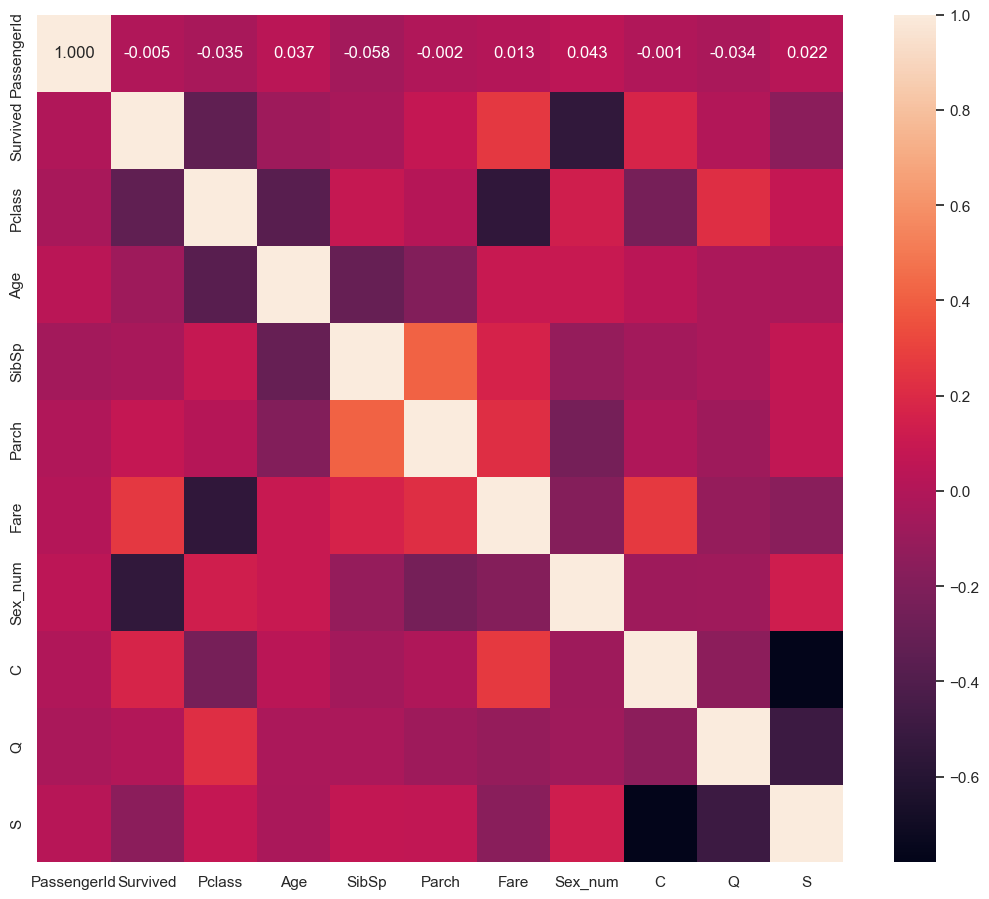

In [116]:
# What does the matrix df.corr() represent? Provide your interpretation of the numbers you see.
sns.set(rc = {'figure.figsize':(13,11)})
sns.heatmap(df.corr(),annot=True, fmt = '.3f')

#The matrix df.corr() represents the correlation matrix for each feature with one another. From this we can see that 
#We should keep in mind of those that are very light in color, and those that are very dark in color.
#survived has a roughly -0.4 correlation with Pclass and has a roughly -0.7 correlation with Sex_num.
#As expected, Pclass has a significant correlation with age and fare.

# Data cleansing
Check the number of missing values in "Age". You can either


*   Do nothing (the rows with missing "Age" will be ignored in the training stage)
*   Or fill the missing values with some value of your choice.


Do something smart.



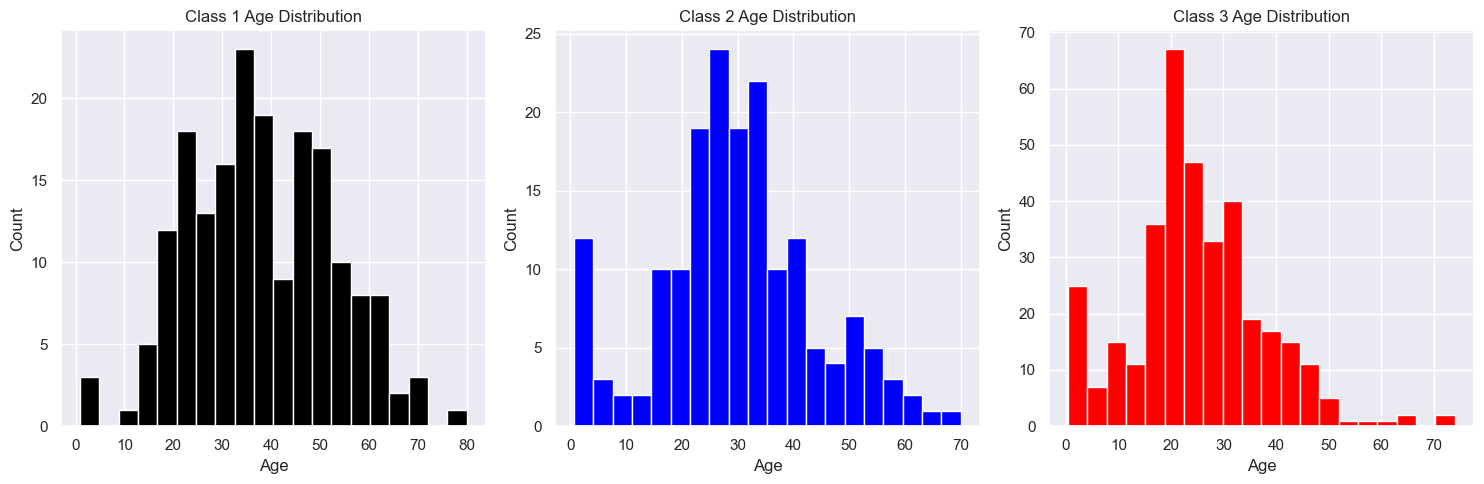

In [126]:
# Do something smart to handle the problem of missing values in the "Age" column

#I would like to first look at the age distribution for each class. We want to use a measure that is representative 
#of the middle-age for each cabin since class is highly correlated with survival rate. The goal of this visualization
#is to determine if mean or median is a better measure. 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

df["Age"][df["Pclass"] == 1].hist(ax=ax1, bins=20, color='black')
df["Age"][df["Pclass"] == 2].hist(ax=ax2, bins=20, color='blue')
df["Age"][df["Pclass"] == 3].hist(ax=ax3, bins=20, color='red')

ax1.set_title("Class 1 Age Distribution")
ax2.set_title("Class 2 Age Distribution")
ax3.set_title("Class 3 Age Distribution")

for ax in (ax1, ax2, ax3):
    ax.set_xlabel("Age")
    ax.set_ylabel("Count")
    
plt.tight_layout()
plt.show()

In [143]:
#Since there ages for class 2 and 3 are both right skewed, I will use median for all 3 classes as my missing values 
#handling method
med_age_class1 = np.nanmedian(df["Age"][df["Pclass"] == 1])
med_age_class2 = np.nanmedian(df["Age"][df["Pclass"] == 2])
med_age_class3 = np.nanmedian(df["Age"][df["Pclass"] == 3])

df.loc[df["Pclass"] == 1, "Age"] = df.loc[df["Pclass"] == 1, "Age"].fillna(med_age_class1)
df.loc[df["Pclass"] == 2, "Age"] = df.loc[df["Pclass"] == 2, "Age"].fillna(med_age_class2)
df.loc[df["Pclass"] == 3, "Age"] = df.loc[df["Pclass"] == 3, "Age"].fillna(med_age_class3)

#check if all nan values are filled
print(df["Age"].isna().any())

False


In [144]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Sex_num', 'C', 'Q', 'S'],
      dtype='object')

In [167]:
# We will train a logistic regression. Write below the columns which you would like to keep as features for logistic regression.
# n.b.: We will NOT keep the columns Ticket and Cabin. Why?
# we don't keep tickets and cabin because ticket is unique to each user. Cabin contains a lot of nan values and has
# overlapping "information" with the Pclass column

#I am choosing Age, Pclass, Sex_num, C, Q, and S, and Fare as my parameters. 

mycolumns = ["Age", "Pclass", "Sex_num", "C", "Q", "S", "Fare"]


#Logistic regression


In [168]:
# Train a logistic regression classifier using sklearn, based on the above dataframe and the chosen columns.
# Explain the meaning of the parameter in the logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2',C=1.0,max_iter=1000)

In [169]:
# Fit the model
X = df[mycolumns]
y = df["Survived"]

model = lr.fit(X, y)

In [173]:
# Display the coefficients of the logistic regression. Discuss the possible positive/negative impact on survival of certain parameters

#males are 1, females are 0
#We can see that Age, Pclass, Sex_num (men = 1), Travelling from Southampton, and Fare has a negative impact of survival
#whereas travelling from Cherbourg Queenstown has a positive impact on survival. 

feature_weights = dict(zip(mycolumns, model.coef_.flatten()))
print(feature_weights)

{'Age': -0.03536154658523816, 'Pclass': -1.1952293054912837, 'Sex_num': -2.488188075631324, 'C': 0.09847096120453906, 'Q': 0.040394899484321775, 'S': -0.3860778111015226, 'Fare': -0.00017080651521656008}


# Performance evaluation


In [198]:
# Load the test data
Xtest = pd.read_csv("testtitanic.csv")
ytest = pd.read_csv("gender_submission.csv")
dftest = pd.merge(Xtest,ytest)

In [199]:
df.columns
dftest.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'],
      dtype='object')

In [202]:
# Process the test features in order to obtain the same format as for the train set
#convert sex to binary
dftest["Sex_num"] = (dftest["Sex"] == "male").astype("int")

#one-hot encoding
one_hot_test = pd.get_dummies(dftest["Embarked"])
dftest = pd.concat([dftest, one_hot_test], axis = 1)

#drop embarked and sex
dftest_ = dftest.drop(columns = ["Sex", "Embarked"])
dftest_.head(10)

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Survived,Sex_num,C,Q,S
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,1,0,0,0,1
5,897,3,"Svensson, Mr. Johan Cervin",14.0,0,0,7538,9.2250,NaN,0,1,0,0,1
6,898,3,"Connolly, Miss. Kate",30.0,0,0,330972,7.6292,NaN,1,0,0,1,0
7,899,2,"Caldwell, Mr. Albert Francis",26.0,1,1,248738,29.0000,NaN,0,1,0,0,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.0,0,0,2657,7.2292,NaN,1,0,1,0,0
9,901,3,"Davies, Mr. John Samuel",21.0,2,0,A/4 48871,24.1500,NaN,0,1,0,0,1


In [203]:
# Define a dataframe with only the columns you want to keep (and the label)
dftest_ = dftest_[mycolumns + ["Survived"]]
dftest_.head()

,Age,Pclass,Sex_num,C,Q,S,Fare,Survived
0,34.5,3,1,0,1,0,7.8292,0
1,47.0,3,0,0,0,1,7.0000,1
2,62.0,2,1,0,1,0,9.6875,0
3,27.0,3,1,0,0,1,8.6625,0
4,22.0,3,0,0,0,1,12.2875,1


In [220]:
# Check if there are some missing values. If needed, row containing missing values can be dropped using the dropna() method (inplace)
dftest_ = dftest_.dropna()

False

In [313]:
# Compute the hard predictions on the test set (using only the columns to keep)
y_pred = model.predict(dftest_[mycolumns])

In [230]:
# Compute the accuracy score
from sklearn.metrics import accuracy_score

y_test = dftest_["Survived"]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score is: {accuracy}")

Accuracy score is: 0.9244712990936556


In [245]:
# Compute the soft predictions using predict_proba
ls_probabilities = model.predict_proba(df[mycolumns])

survived_preds = ls_probabilities[:, 0,]
dead_pred = ls_probabilities[:, 1,]

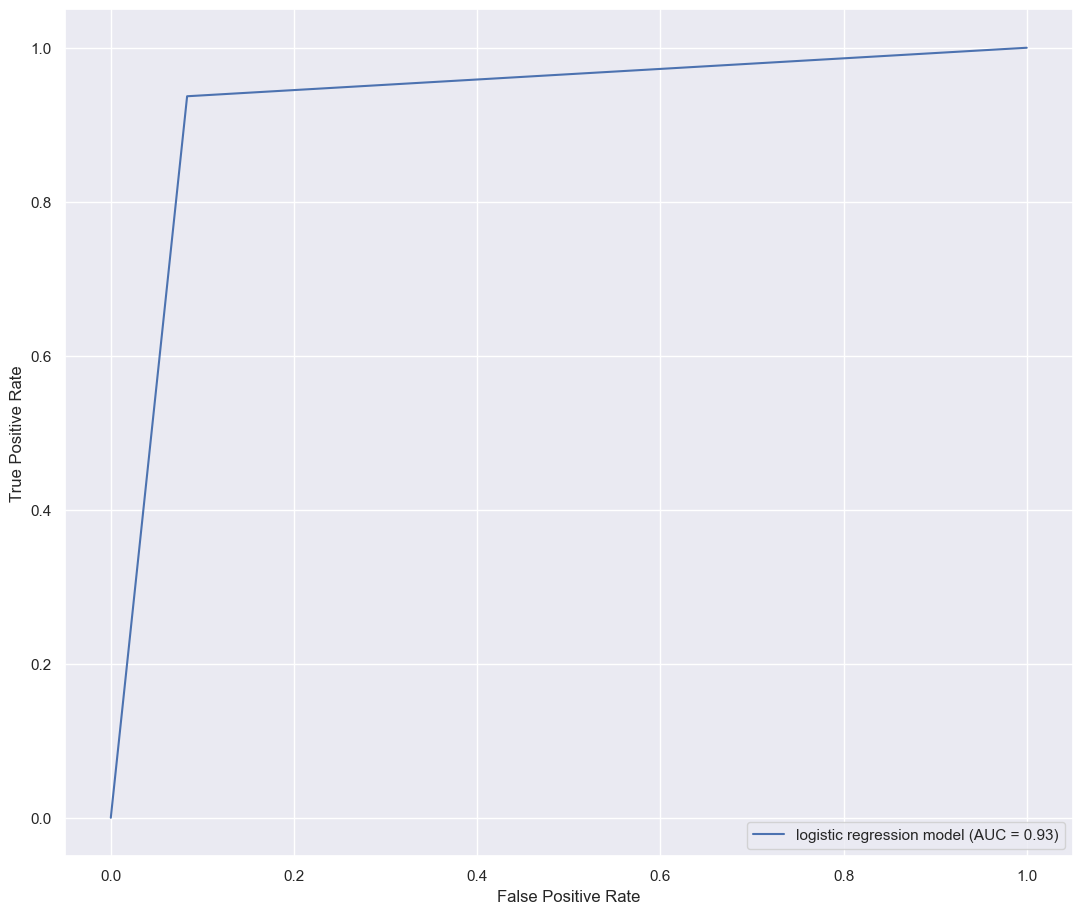

In [256]:
from sklearn.metrics import RocCurveDisplay

y = y_test
pred = y_pred

fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr = fpr, 
                                  tpr = tpr, 
                                  roc_auc = roc_auc, 
                                  estimator_name = "logistic regression model")
display.plot()
plt.show()

In [263]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

power = tpr[1]
recall = recall_score(y, y_pred)
precision = precision_score(y, y_pred)


print(f"ROC AUC: {roc_auc}")
print(f"Power: {power}")
print(f"recall: {recall}")
print(f"precision: {precision}")

ROC AUC: 0.9268372703412073
Power: 0.937007874015748
recall: 0.937007874015748
precision: 0.875


# Bonus question: do whatever you find useful

Here are some examples:

*   Try to include useful elements of the Cabin number
*   Try different regularization parameters
* Try L1 regularization instead of ridge
* Try linear regression





In [300]:
from sklearn.model_selection import GridSearchCV

#try L1 (lasso) instead of L2
#L1 in this case yields a slightly higher ROC_AUC curve when we select lambda as 0.1
#try different lambda values; C = 1/lambda
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(penalty = 'l1', solver = 'liblinear'), 
                           param_grid, cv = 5)

grid_search.fit(df[mycolumns], df["Survived"])

best_params = grid_search.best_params_
model_bonus = LogisticRegression(**best_params, random_state = 42)
model_bonus.fit(df[mycolumns], df["Survived"])
pred_bonus = model_bonus.predict(dftest_[mycolumns])

fpr_bonus, tpr_bonus, thresholds_bonus = metrics.roc_curve(y_test, pred_bonus)
roc_auc_bonus = metrics.auc(fpr_bonus, tpr_bonus)

print("Best lambda: ", 1/grid_search.best_params_.get('C'))
print("roc_auc: ", roc_auc_bonus)

Best lambda:  0.1
roc_auc:  0.9307742782152232


/Users/Andrew/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [318]:
#try linear regression
#linear regression actually had the highest ROC_AUC score after transforming the predictions
#into binary survived values with the threshold at 0.5
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
X_train = df[mycolumns]
X_test = dftest_[mycolumns]
y_train = df["Survived"]
y_test = dftest_["Survived"]

model_LR = LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)
y_pred_bin = np.where(y_pred > 0.5, 1, 0)
fpr_LR, tpr_LR, thresholds_LR = metrics.roc_curve(y_test, y_pred_bin)
roc_auc_LR = metrics.auc(fpr_LR, tpr_LR)

roc_auc_LR


0.9700671607225568